In [4]:
from scipy.integrate import odeint
import numpy as np
import matplotlib.pyplot as plt
from random import shuffle, seed

from echo_state_network import ESN

Equation for the first pendulum: $mL\ddot{\theta_{1}} = -gmsin(\theta_{1}) - kLsin(\theta_{1} - \theta_{2})$

Equation for the second pendulum: $mL\ddot{\theta_{2}} = -gmsin(\theta_{2}) + kLsin(\theta_{1} - \theta_{2})$

# Equation independent of the second angle to get started

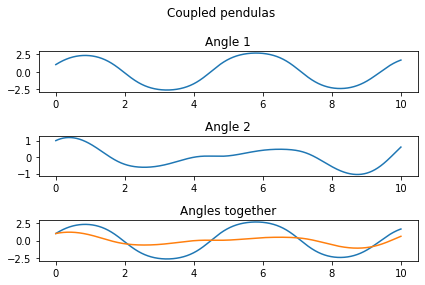

In [9]:
L_1 = 3
g_1 = 9.81
k_1 = 2
m_1 = 2

def coupled_pendulum(w, t, p):
    # x_i = theta_i
    # y_i = theta_i'
    # Return [theta1', theta1'', theta2', theta2'']
    # In our terminology: [y1, y1', y2, y2']
    
    x1, y1, x2, y2 = w
    g, L, k, m = p
    
    theta1_double_prime = - g/L * np.sin(x1) - k/m * np.sin(x1 - x2) # Phase difference
    theta2_double_prime = - g/L * np.sin(x2) - k/m * np.sin(x2 - x1) # Phase difference, but adjusted for -
    
    return [y1, theta1_double_prime, y2, theta2_double_prime]


def compute_L2(data1, data2):
    return ((data1 - data2) ** 2).sum()


def getESN(input_channels, n_reservoir, spectral_radius, sparsity, noise, teacher_forcing):
    return ESN(
        input_channels, 
        1, 
        n_reservoir=n_reservoir,
        spectral_radius=spectral_radius,
        sparsity=sparsity,
        noise=noise, 
        input_shift=None,
        input_scaling=None, 
        teacher_forcing=teacher_forcing, 
        feedback_scaling=None,
        teacher_scaling=None, 
        teacher_shift=None,
        out_activation=lambda x: x, #tanh, sigmoid
        inverse_out_activation=lambda x: x, #TODO ?
        random_state=None, 
        silent=True
    )

t = np.linspace(0, 10, num=10000)

# Pack up the parameters and initial conditions:
p = [g_1, L_1, k_1, m_1]

#Initial values
w0 = [1, 3, 1, 1]

abserr = 1.0e-8
relerr = 1.0e-6

# Call the ODE solver.
solution = odeint(coupled_pendulum, w0, t, args=(p,), atol=abserr, rtol=relerr)
angle1 = solution[:, 0]
angle2 = solution[:, 2]

fig, axs = plt.subplots(3)
fig.suptitle('Coupled pendulas')

axs[0].set_title('Angle 1')
axs[1].set_title('Angle 2')
axs[2].set_title('Angles together')
fig.tight_layout()

axs[0].plot(t, angle1)
axs[1].plot(t, angle2)
axs[2].plot(t, angle1, t, angle2)

## Predictions on the first angle using ESN, numerical solution using time input

6.004209189468286 Sum square


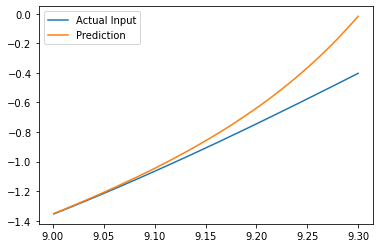

In [12]:
esn = getESN(1, 2000, 0.5, 0.2, 0, False)

cutoff = int(len(t) * 0.9)

t_train = t[:cutoff]
y_train = angle1[:cutoff]
t_test = t[cutoff:]
y_test = angle1[cutoff:]

N = 300
weights = esn.fit(t_train, y_train)
pred = esn.predict(t_test[:N], True)[:, 0]

print(((pred - y_test[:N]) ** 2).sum(), 'Sum square')

plt.plot(t_test[:N], y_test[:N], t_test[:N], pred)
plt.legend(['Actual Input', 'Prediction'])

# Error analysis of time series prediction using time input

## L2 distance on step size

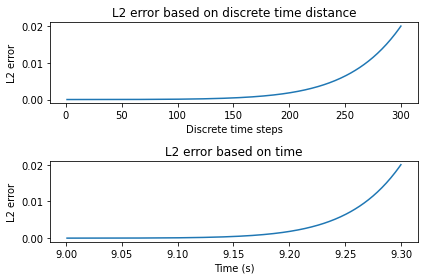

In [13]:
errs = []

pred = esn.predict(t_test)[:, 0]

for i in range(1, N + 1):
    errs.append(((pred[:i] - y_test[:i]) ** 2).mean())

fig, ax = plt.subplots(2)
    
ax[0].plot(list(range(1, N + 1)), errs)
ax[0].set_title('L2 error based on discrete time distance')
ax[0].set_xlabel('Discrete time steps')
ax[0].set_ylabel('L2 error')

ax[1].plot(t_test[:N], errs)
ax[1].set_title('L2 error based on time')
ax[1].set_xlabel('Time (s)')
ax[1].set_ylabel('L2 error')

#TODO: Normalize WRT to std of time series (L2(prediction, ground_truth).mean()) / variance(ground_truth)

fig.tight_layout()

## L2 distance based on reservoir size

In this step we will fix the time steps at 300, spectral radius at 0.5, sparsity at 0.2, noise at 0. The number of reservoirs will be increased in increments of a 100, and will go from a 100 to 2000

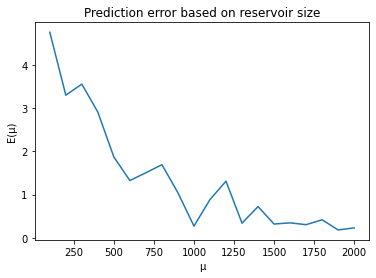

In [148]:
err = []
steps = list(range(100, 2001, 100))

# TODO for hyperparameters do averaging?
# TODO I think we need averaging here

# TODO also get training error
for number_of_reservoirs in steps:
    m = []
    
    print('Processing number of reservoirs:', number_of_reservoirs)
    
    for _ in range(10):
        esn = getESN(1, number_of_reservoirs, 0.5, 0.2, 0, False)
        weights = esn.fit(t_train, y_train)
        
        pred = esn.predict(t_test[:N])
        m.append(((pred - y_test[:N]) ** 2).mean())
        
    err.append(np.array(m).mean())
    
plt.plot(steps, err)
plt.xlabel('\u03BC')
plt.ylabel('E(\u03BC)')
plt.title('Prediction error based on reservoir size')

plt.savefig('Error on reservoir size', bbox_inches='tight')

# Mean squared error, normalize with respect to the variance
# After 1500 not much improvement

## Error dependece on sparsity

Processing sparsity: 0.05
Processing sparsity: 0.1
Processing sparsity: 0.15000000000000002
Processing sparsity: 0.2
Processing sparsity: 0.25
Processing sparsity: 0.3
Processing sparsity: 0.35000000000000003
Processing sparsity: 0.4
Processing sparsity: 0.45
Processing sparsity: 0.5
Processing sparsity: 0.55
Processing sparsity: 0.6000000000000001
Processing sparsity: 0.6500000000000001
Processing sparsity: 0.7000000000000001
Processing sparsity: 0.7500000000000001
Processing sparsity: 0.8
Processing sparsity: 0.8500000000000001
Processing sparsity: 0.9000000000000001
Processing sparsity: 0.9500000000000001


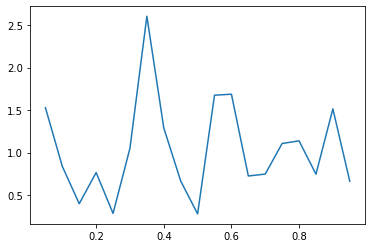

In [24]:
err = []
steps = np.arange(0.05, 1, 0.05)

for sparsity in steps:
    m = []
    
    print('Processing sparsity:', sparsity)
    
    for _ in range(10):
        esn = getESN(1, 1000, 0.5, sparsity, 0, False)
        weights = esn.fit(t_train, y_train)
        
        pred = esn.predict(t_test[:N])
        m.append(((pred - y_test[:N]) ** 2).mean())
        
    err.append(np.array(m).mean())
    
    
# Sparsity is related to spectral radius

# TODO: Check relation to sparsity and spectral radius
# TODO: Do a 2D plot of spectral radius, and sparsity in comparison to error

plt.plot(steps, err)

## Error dependence on spectral radius

[0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7 1.8
 1.9 2. ]
Processing sparsity: 0.1
Processing sparsity: 0.2
Processing sparsity: 0.30000000000000004
Processing sparsity: 0.4
Processing sparsity: 0.5
Processing sparsity: 0.6
Processing sparsity: 0.7000000000000001
Processing sparsity: 0.8
Processing sparsity: 0.9
Processing sparsity: 1.0
Processing sparsity: 1.1
Processing sparsity: 1.2000000000000002
Processing sparsity: 1.3000000000000003
Processing sparsity: 1.4000000000000001
Processing sparsity: 1.5000000000000002
Processing sparsity: 1.6
Processing sparsity: 1.7000000000000002
Processing sparsity: 1.8000000000000003
Processing sparsity: 1.9000000000000001
Processing sparsity: 2.0


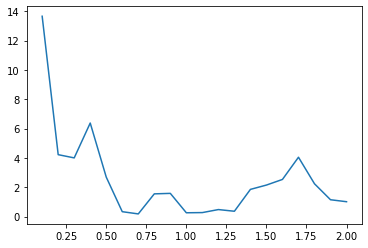

In [28]:
err = []
steps = np.arange(0.1, 2.1, 0.1)

print(steps)

for spectral_radius in steps:
    m = []
    
    print('Processing spectral radius:', spectral_radius)
    
    for _ in range(10):
        esn = getESN(1, 500, spectral_radius, 0.1, 0, False)
        weights = esn.fit(t_train, y_train)
        
        pred = esn.predict(t_test[:N])
        m.append(((pred - y_test[:N]) ** 2).mean())
        
    err.append(np.array(m).mean())
    
plt.plot(steps, err)

# Prediction with second angle as input

Text(0.5, 1.0, 'Angle prediction based on time and angle')

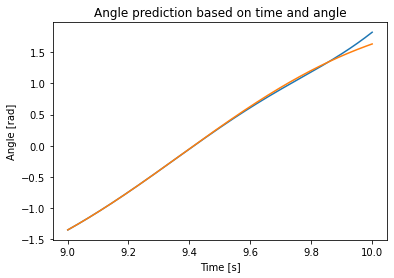

In [37]:
training_data_input = np.column_stack((t[:cutoff], angle2[:cutoff]))
training_data_output = angle1[:cutoff]

validation_data_input = np.column_stack((t[cutoff:], angle2[cutoff:]))
validation_data_output = angle1[cutoff:]

esn = getESN(2, 2000, 0.5, 0.2, 0, False)

weights = esn.fit(training_data_input, training_data_output)

pred = esn.predict(validation_data_input)[:,0]

print('L2 loss:', compute_L2(pred, validation_data_output))

plt.plot(validation_data_input[:,0], pred, validation_data_input[:, 0], validation_data_output)
plt.xlabel('Time [s]')
plt.ylabel('Angle [rad]')
plt.title('Angle prediction based on time and angle')

# Look into synchrony between input parameters and reservoir states

# Analytic approximation

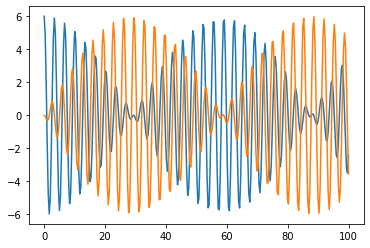

In [142]:
# https://phys.libretexts.org/Bookshelves/University_Physics/Book%3A_Mechanics_and_Relativity_(Idema)/08%3A_Oscillations/8.04%3A_Coupled_Oscillators
def compute_angles(time, initial_angle, k, g, l):
    omega_prime = np.sqrt(2 * k + g/l)
    omega_0 = np.sqrt(g/l)
    inner_term_1 = ((omega_0 + omega_prime) / 2) * t 
    inner_term_2 = ((omega_0 - omega_prime) / 2) * t
    
    angle1 = initial_angle * np.cos(inner_term_1) * np.cos(inner_term_2)
    angle2 = initial_angle * np.sin(inner_term_1) * np.sin(inner_term_2)
    
    return angle1, angle2

t = np.linspace(0, 100, 300)
initial_angle = 6
k = 0.2
g = 9.81
l = 3

angle1, angle2 = compute_angles(t, initial_angle, k, g, l)

plt.plot(t, angle1, t, angle2)

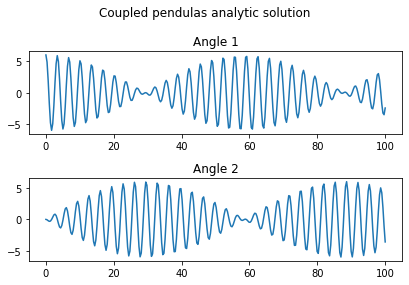

In [143]:
fig, axs = plt.subplots(2)
fig.suptitle('Coupled pendulas analytic solution')

axs[0].set_title('Angle 1')
axs[1].set_title('Angle 2')
fig.tight_layout()

axs[0].plot(t, angle1)
axs[1].plot(t, angle2)

# Predicting Angle 1 of coupled pendulum analytical solution with small angle approximation

harvesting states...
fitting...
training error:
2.606965194083856
L^2 error 2220240.121911047


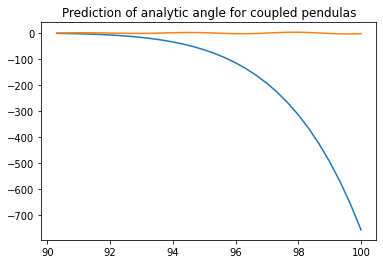

In [144]:
esn = getESN(1, 600, 0.2, 0.1, 0, False)

cutoff = int(len(t) * 0.9)

training_data_output = angle1[:cutoff]
training_data_input = t[:cutoff]

validation_data_output = angle1[cutoff:]
validation_data_input = t[cutoff:]

weights = esn.fit(training_data_input, training_data_output)

prediction = esn.predict(validation_data_input)[:,0]

plt.plot(validation_data_input, prediction, validation_data_input, validation_data_output)
plt.title('Prediction of analytic angle for coupled pendulas')

print('L^2 error', compute_L2(validation_data_output, prediction))

# Introducing 2nd channel, the angle of the 2nd pendulum

harvesting states...
fitting...
training error:
0.20678164261172358


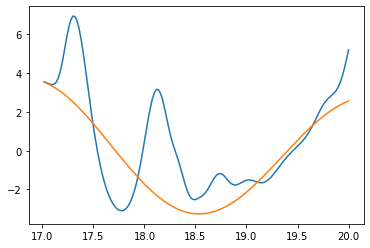

In [126]:
esn = getESN(2, 1000, 1, 0.3, 0, False)

angle_training_input = angle2[:cutoff]
time_training_input = t[:cutoff]

angle_validation_input = angle2[cutoff:]
time_validation_input = t[cutoff:]

training_data_input = np.column_stack((time_training_input, angle_training_input))
validation_data_input = np.column_stack((time_validation_input, angle_validation_input))

weights = esn.fit(training_data_input, training_data_output)

prediction = esn.predict(validation_data_input)[:,0]

plt.plot(time_validation_input, prediction, time_validation_input, validation_data_output)